# Домашнее задание
## Реализация алгоритма Deep Feature Interpolation

### План

1. Изучите алгоритм, описанный в [статье](https://arxiv.org/pdf/1611.05507.pdf).
2. Скачайте датасет (`faces.tar`) и разархивируйте его.
3. Реализуйте алгоритм **Deep Feature Interpolation**.
4. Продемонстрируйте результаты работы на произвольном изображении.

### Критерии оценки

* реализация базового алгоритма (с демонстрацией работы на каком-нибудь изображении из выборки): **50 баллов**
* визуализация интерполяции (варьировать степень модификации изменением $\alpha$): **30 баллов**
* применить алгоритм к какой-нибудь картике не из выборки (с применением детектора и вставкой обратно): **20 баллов**

### Подсказки

* для экономии памяти предлагается хранить в индексе не сами вектора, а их проекции на меньшее пространство (например, в качестве базиса использовать top-256 PCA, посчитанный на 5К-10К объектах выборки), а когда нужно посчитать вектор-смещение, просто пересчитывать необходимое количество
* поэкспериментируйте со взвешиванием основного лосса и полной вариации
* экспериментируйте на изображениях меньшего разрешения (например, 64х64)

In [2]:
from PIL import Image
import numpy as np
import os

import torch
import torch.nn as nn
import torchvision

import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

IMAGE_SIZE = 128

In [3]:
USE_CUDA = True
DEVICE_ID = 2

In [4]:
torch.cuda.is_available()

True

In [5]:
DEVICE = torch.device(('cuda:%d' % DEVICE_ID) if USE_CUDA else 'cpu')

### Загрузка данных

*Предоставляемый датасет был размечен классификатором, поэтому может содержать большое количество ошибок. Тем не менее, для выполнения данного задания это не так критично.*

In [6]:
def load_dataset(directory):
    header = []
    labels = []
    filepaths = []
    
    with open(os.path.join(directory, 'gt.csv')) as f:
        header = f.readline().strip().split()[1:]
        header = [h.lower() for h in header]
        for line in f:
            fields = line.strip().split()
            path = os.path.join(directory, fields[0])
            filepaths.append(path)
            labels.append(fields[1:])

    return (
        header,
        np.array(labels),
        np.array(filepaths)
    )

DATASET_DIRECTORY_PATH = './data/faces'  
header, labels, filepaths = load_dataset(DATASET_DIRECTORY_PATH)

print(f"{len(filepaths)} изображений в датасете")

202278 изображений в датасете


In [7]:
print("Содержимое датасета по категориям:")
for i in range(len(header)):
    print(header[i], ":")
    names, counts = np.unique(labels[:, i], return_counts=True)
    for j in range(len(names)):
        print(" * ", names[j], ":", counts[j])

Содержимое датасета по категориям:
race :
 *  asian : 16215
 *  caucasian : 186063
gender :
 *  female : 134736
 *  male : 67542
age :
 *  adult : 75318
 *  old : 62429
 *  senior : 43973
 *  young : 20558
facial_hair :
 *  beard : 6689
 *  mustache : 2541
 *  shaved : 193048


In [8]:
# функция для удобного взаимодействия с разметкой

def get_mask(**kwargs):
    mask = np.ones(len(filepaths), dtype=np.bool)
    for h in kwargs:
        if isinstance(kwargs[h], list):
            mask &= np.in1d(labels[:, header.index(h)], kwargs[h])
        else:
            mask &= labels[:, header.index(h)] == kwargs[h]
    return mask

def load_image(path, size=(IMAGE_SIZE, IMAGE_SIZE)):
    img = Image.open(path)
    img = img.convert("RGB")
    img = img.resize(size, Image.BICUBIC)
    return img

# примеры запросов
print("count(asian & female) =", get_mask(race='asian', gender='female').sum())
print("count(caucasian & male & shaved) =", get_mask(race='caucasian', gender='male', facial_hair='shaved').sum())

count(asian & female) = 11046
count(caucasian & male & shaved) = 53359


### Функция $\phi(x)$

Определим функцию отображения в признаковое пространство в виде `nn.Module`:


In [9]:
class Phi(nn.Module):
    def __init__(self, pretrained=True):
        super(Phi, self).__init__()

        model = torchvision.models.vgg19(pretrained=pretrained)
        layers = list(model.features)
        self.slice_0 = nn.Sequential(*layers[0:12])
        self.slice_1 = nn.Sequential(*layers[12:21])
        self.slice_2 = nn.Sequential(*layers[21:30])

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        mean = x.new_tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = x.new_tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        x = (x - mean) / std
        
        xs = []

        x = self.slice_0(x)
        xs.append(x.view(x.shape[0], -1))
        
        x = self.slice_1(x)
        xs.append(x.view(x.shape[0], -1))
        
        x = self.slice_2(x)
        xs.append(x.view(x.shape[0], -1))
        
        return torch.cat(xs, 1)
#         return np.concatenate(xs, axis=1)
    

to_tensor = torchvision.transforms.ToTensor()
to_image = torchvision.transforms.ToPILImage()

phi = Phi()

number of features per image:  425984


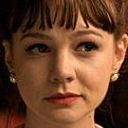

In [10]:
# пример использования

image = load_image(filepaths[0])
fx = phi(to_tensor(image).unsqueeze(0))[0]

print("number of features per image: ", fx.shape[0])
image

### Построение индекса базы

Извлеките признаки (функцией $\phi$) из изображений базы. По этим признакам вы будете искать похожие изображения, поэтому можно хранить их сжатое представление.

Сперва сделаем `dimensionality reduction`

In [11]:
BATCH_SIZE = 5000
FILEPATHS_LEN  = len(filepaths)
LEN_BATCH_RATIO = FILEPATHS_LEN // BATCH_SIZE
FEATURES_BACKUP_PATH = './data/backup/'

In [12]:
def get_images(range_, use_tqdm=False):
    batch = []
    
    if use_tqdm:
        range_ = tqdm.tqdm_notebook(range_)
        
    for i in range_:
        cur_tensor = to_tensor(load_image(filepaths[i])).unsqueeze(0)
        batch.append(cur_tensor)
    return torch.cat(batch)

In [14]:
from sklearn.decomposition import PCA

In [15]:
pca = PCA(n_components=250, random_state=42)

In [17]:
%%time
train_images = get_images(range(0, BATCH_SIZE), True)
train_features = phi(train_images).numpy()
pca.fit(train_features)

CPU times: user 55min 49s, sys: 14min 17s, total: 1h 10min 6s
Wall time: 9min 40s


In [38]:
LAST_SUCC_BATCH = 40

In [39]:
if LAST_SUCC_BATCH == -1:
    f = None
else:
    f = np.load(FEATURES_BACKUP_PATH + 'epoch_{}.npy'.format(LAST_SUCC_BATCH))

In [25]:
for epoch in tqdm.tqdm_notebook(range(LAST_SUCC_BATCH + 1, 1 + LEN_BATCH_RATIO)):
    range_ = range(epoch * BATCH_SIZE, min((epoch + 1) * BATCH_SIZE, FILEPATHS_LEN))
    
    feature_batch = phi(get_images(range_)).numpy()
    pca_batch = pca.transform(feature_batch)
    if features is None:
        features = pca_batch
    else:
        features = np.vstack((features, pca_batch))
    np.save(FEATURES_BACKUP_PATH + 'epoch_{}'.format(epoch), features)

In [59]:
np.save(FEATURES_BACKUP_PATH + 'final', features)

In [60]:
assert(FILEPATHS_LEN == features.shape[0])

### Функция подбора кандидатов

У нас есть база признаков, по которым мы можем искать изображения, похожие на запрос. Напишите функцию, которая для данного изображения `query` находит `n` наиболее похожих на него (по сжатому признаковому описанию) среди изображений, покрываемых бинарной маской `mask` (размер маски равен количеству изображений в базе). В качестве меры похожести можете использовать косинусную меру.

In [61]:
from sklearn.metrics.pairwise import cosine_distances

In [92]:
def best_similar(query_image, mask, n=100):
    tensor_image = to_tensor(query_image)
    if len(tensor_image.shape) == 3:
        tensor_image = tensor_image.unsqueeze(0)
        
    feature_vector = phi(tensor_image)
    pca_feature_vector = pca.transform(feature_vector).reshape(1, -1)
    
    cos_distances = cosine_distances(pca_feature_vector, features[mask])
    similar_indexes = np.argsort(cos_distances)[0][:n]
    return np.nonzero(mask)[0][similar_indexes]

### Вычисление центров кластеров

Используя функцию `best_similar` реализуйте функцию подсчёта центров кластеров в признаковом пространстве $\phi$ изображений, наиболее похожих на изображение-запрос. С использованием этой функции вы сможете для двух различных наборов атрибутов (например `caucasian & male` и `asian & male`) вычислить вектор-смещение, по которому мы будем "двигать" признаковое описание оптимизируемого изображения. 

*Заметьте, что если мы будем производить модификацию из `caucasian & male` в `asian & male`, то изображение, которое мы оптимизируем, должно принадлежать множеству `caucasian & male`, иначе результат может получиться так себе.*

In [122]:
def class_centre(query_image, mask):
    similar_indexes = best_similar(query_image, mask)
    similar_images = get_images(similar_indexes)
    similars_features = phi(similar_images)
    return similars_features.mean(dim=0)

### Функция потерь

Реализуйте функцию потерь, которую мы будем минимизировать для выбранного изображения и вычисленного для него вектора смещения.

In [123]:
torch.cuda.set_device(DEVICE_ID)

In [167]:
# Reverse mapping
class TVLoss(nn.Module):
    def __init__(self,TVLoss_weight=0.001):
        super(TVLoss,self).__init__()
        self.TVLoss_weight = TVLoss_weight

    def forward(self,x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self._tensor_size(x[:,:,1:,:])
        count_w = self._tensor_size(x[:,:,:,1:])
        h_tv = torch.pow((x[:,:,1:,:]-x[:,:,:h_x-1,:]),2).sum()
        w_tv = torch.pow((x[:,:,:,1:]-x[:,:,:,:w_x-1]),2).sum()
        return self.TVLoss_weight*2*(h_tv/count_h+w_tv/count_w)/batch_size

    def _tensor_size(self,t):
        return t.size()[1]*t.size()[2]*t.size()[3]

In [180]:
def calc_loss(feature_vector, image_tensor, reg_mse=0.5, reg_tv=0.05):
    image_features = phi.forward(image_tensor)
    
    mse = nn.MSELoss().cuda()
    tv = TVLoss().cuda()
    return  reg_mse * mse(image_features, feature_vector) + reg_tv * tv(image_tensor)

### Оптимизиация

Напишите код оптимизиации изображения с использованием какого-нибудь оптимизатора.

In [312]:
def reverse_mapping(feature_vector, image_tensor, num_epochs=15, use_tqdm=False):
    feature_vector = feature_vector.cuda()
    image_tensor = image_tensor.cuda()
    phi.cuda()
    
    result = image_tensor.clone().requires_grad_()
    optimizer = torch.optim.LBFGS([result])
    
    range_ = range(num_epochs)
    if use_tqdm:
        range_ = tqdm.tqdm_notebook(range_)
        
    for t in range_:
        def closure():
            optimizer.zero_grad()
            loss = calc_loss(feature_vector, result)
            loss.backward()
            return loss

        optimizer.step(closure)
        result.data.clamp_(0,1)
        
    phi.cpu()
    feature_vector.cpu()
    return result.detach().cpu()

In [313]:
def deep_feature_interpolation_rough(source_image, source_mask, target_mask, alpha=None, beta=0.4):
    phi.cpu()
    
    phi_source_mean = class_centre(source_image, source_mask)
    phi_target_mean   = class_centre(source_image, target_mask)
    w = phi_target_mean - phi_source_mean
    
#     calculate alpha according to the paper
    if alpha is None:
        alpha = (beta*w.shape[0])/torch.pow(w, 2).sum()

    
    source_image_tensor = to_tensor(source_image).unsqueeze(0)
    source_feature_vector = phi(source_image_tensor).view(-1)
    target_feature_vector = source_feature_vector + alpha * w
    
    result_tensor = reverse_mapping(target_feature_vector, source_image_tensor).data.clamp_(0,1)[0]
    return result_tensor
    


### Устранение артефактов (желательно)

В результате оптимизации на изображении могут появиться нежелательные артифакты в виде смещения цетовой палитры. Попробуйте побороть это вычитанием из результата разницы между исходным изображением и модифицированным изображением с параметром $\alpha=0$.

In [319]:
def deep_feature_interpolation_cleared(source_image, source_mask, target_mask, alpha=None, beta=0.4):
    result_tensor_rough = deep_feature_interpolation_rough(source_image, source_mask, 
                                                           target_mask, alpha, beta
                                                          )
    source_image_tensor = to_tensor(source_image).unsqueeze(0)
    source_feature_vector = phi(source_image_tensor).view(-1)
    
    noise = reverse_mapping(source_feature_vector, source_image_tensor)
    
    result_tensor_cleared = (result_tensor_rough + (source_image_tensor - noise)).data.clamp_(0, 1)[0]
    
    return result_tensor_cleared

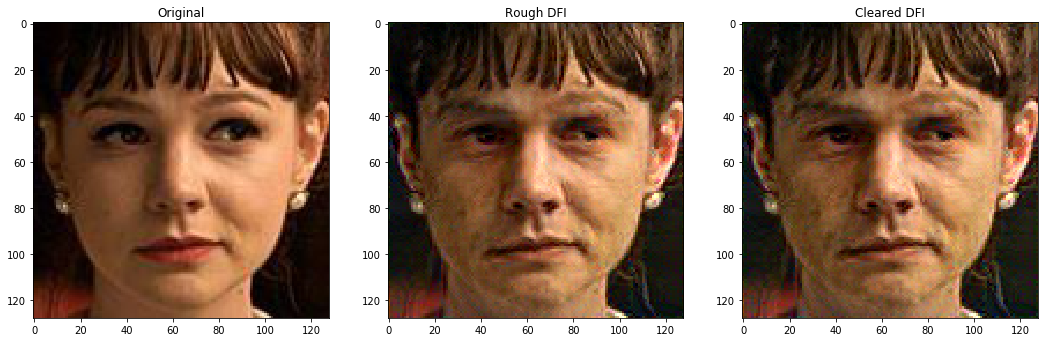

In [315]:
# visualization

alpha=4.

source_image = load_image(filepaths[0])
source_mask = get_mask(race='caucasian', gender='female', age='adult')
target_mask = get_mask(race='caucasian', gender='male', age='adult')

_, axes = plt.subplots(1, 3, figsize=(18, 12))

# 1 show original
axes[0].imshow(source_image)
axes[0].set_title('Original')

# 2 dfi rough
dfi_rough = deep_feature_interpolation_rough(source_image, source_mask, target_mask, alpha)
axes[1].imshow(to_image(dfi_rough))
axes[1].set_title('Rough DFI')

# 3 cleared
dfi_cleared = deep_feature_interpolation_cleared(source_image, source_mask, target_mask, alpha)
axes[2].imshow(to_image(dfi_cleared))
axes[2].set_title('Cleared DFI')

plt.show()

### Интерполяция в признаковом пространстве (бонус)

Постройте последовательность изображений с варьированием степени модификации.

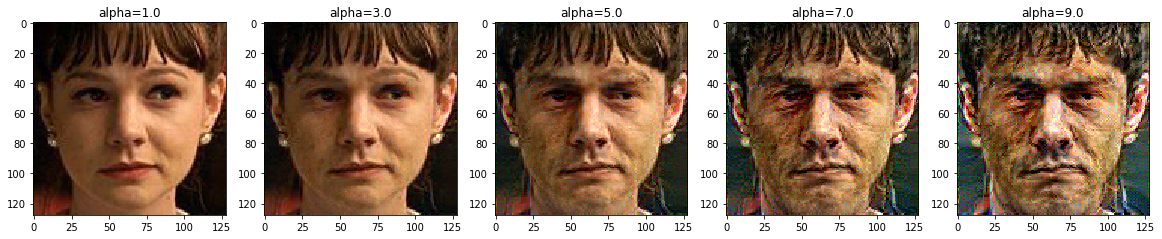

In [320]:
alphas = np.linspace(1., 9., 5)

_, axes = plt.subplots(1, 5, figsize=(20, 25))
for i in tqdm.tqdm_notebook(range(len(alphas))):
    img = to_image(deep_feature_interpolation_cleared(source_image, source_mask, target_mask, alphas[i]))
    axes[i].imshow(img)
    axes[i].set_title('alpha={}'.format(alphas[i]))

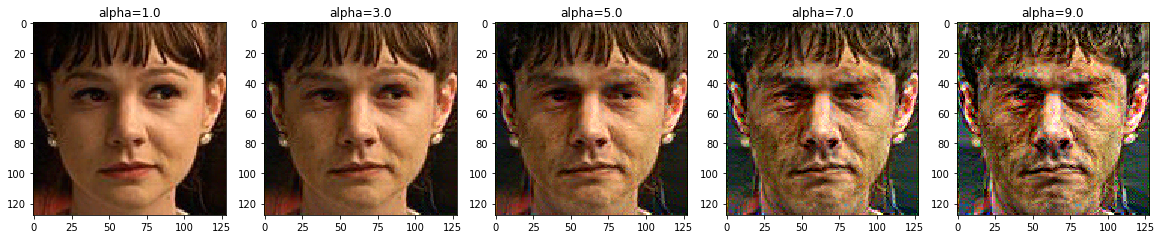

In [316]:
alphas = np.linspace(1., 9., 5)

_, axes = plt.subplots(1, 5, figsize=(20, 25))
for i in tqdm.tqdm_notebook(range(len(alphas))):
    img = to_image(deep_feature_interpolation_rough(source_image, source_mask, target_mask, alphas[i]))
    axes[i].imshow(img)
    axes[i].set_title('alpha={}'.format(alphas[i]))

### Работа с изображениями не из базы (бонус)

Ниже приведена функция `get_face_bbox`, которая возращает координаты для кропа лица из изображения. Используйте её, чтобы вырезать изображение лица, произвести над ним какую-нибудь трансформацию (например, смена пола или расы), а затем вставить модифицированное изображение обратно.

In [300]:
url_downey_jr = 'http://www.rabstol.net/uploads/gallery/main/93/rabstol_net_robert_downey_jr_11.jpg'
source_mask = get_mask(race='caucasian', gender='male', age='adult', facial_hair='shaved')
target_mask = get_mask(race='caucasian', gender='female', age='adult', facial_hair='shaved')

In [301]:
import cv2
import requests
from io import BytesIO


HAAR_CASCADE_FILEPATH = './data/haarcascade_frontalface_default.xml'
cascade = cv2.CascadeClassifier(HAAR_CASCADE_FILEPATH)

def get_face_bbox(image):
    faces = cascade.detectMultiScale(
        np.asarray(image),
        scaleFactor=1.3,
        minNeighbors=5,
        minSize=(50, 50),
        flags=cv2.CASCADE_SCALE_IMAGE)
    if len(faces) != 1:
        return None
    x, y, w, h = faces[0]
    return x, y, x + w, y + h

In [302]:
downey_jr_img = Image.open(BytesIO(requests.get(url_downey_jr).content))

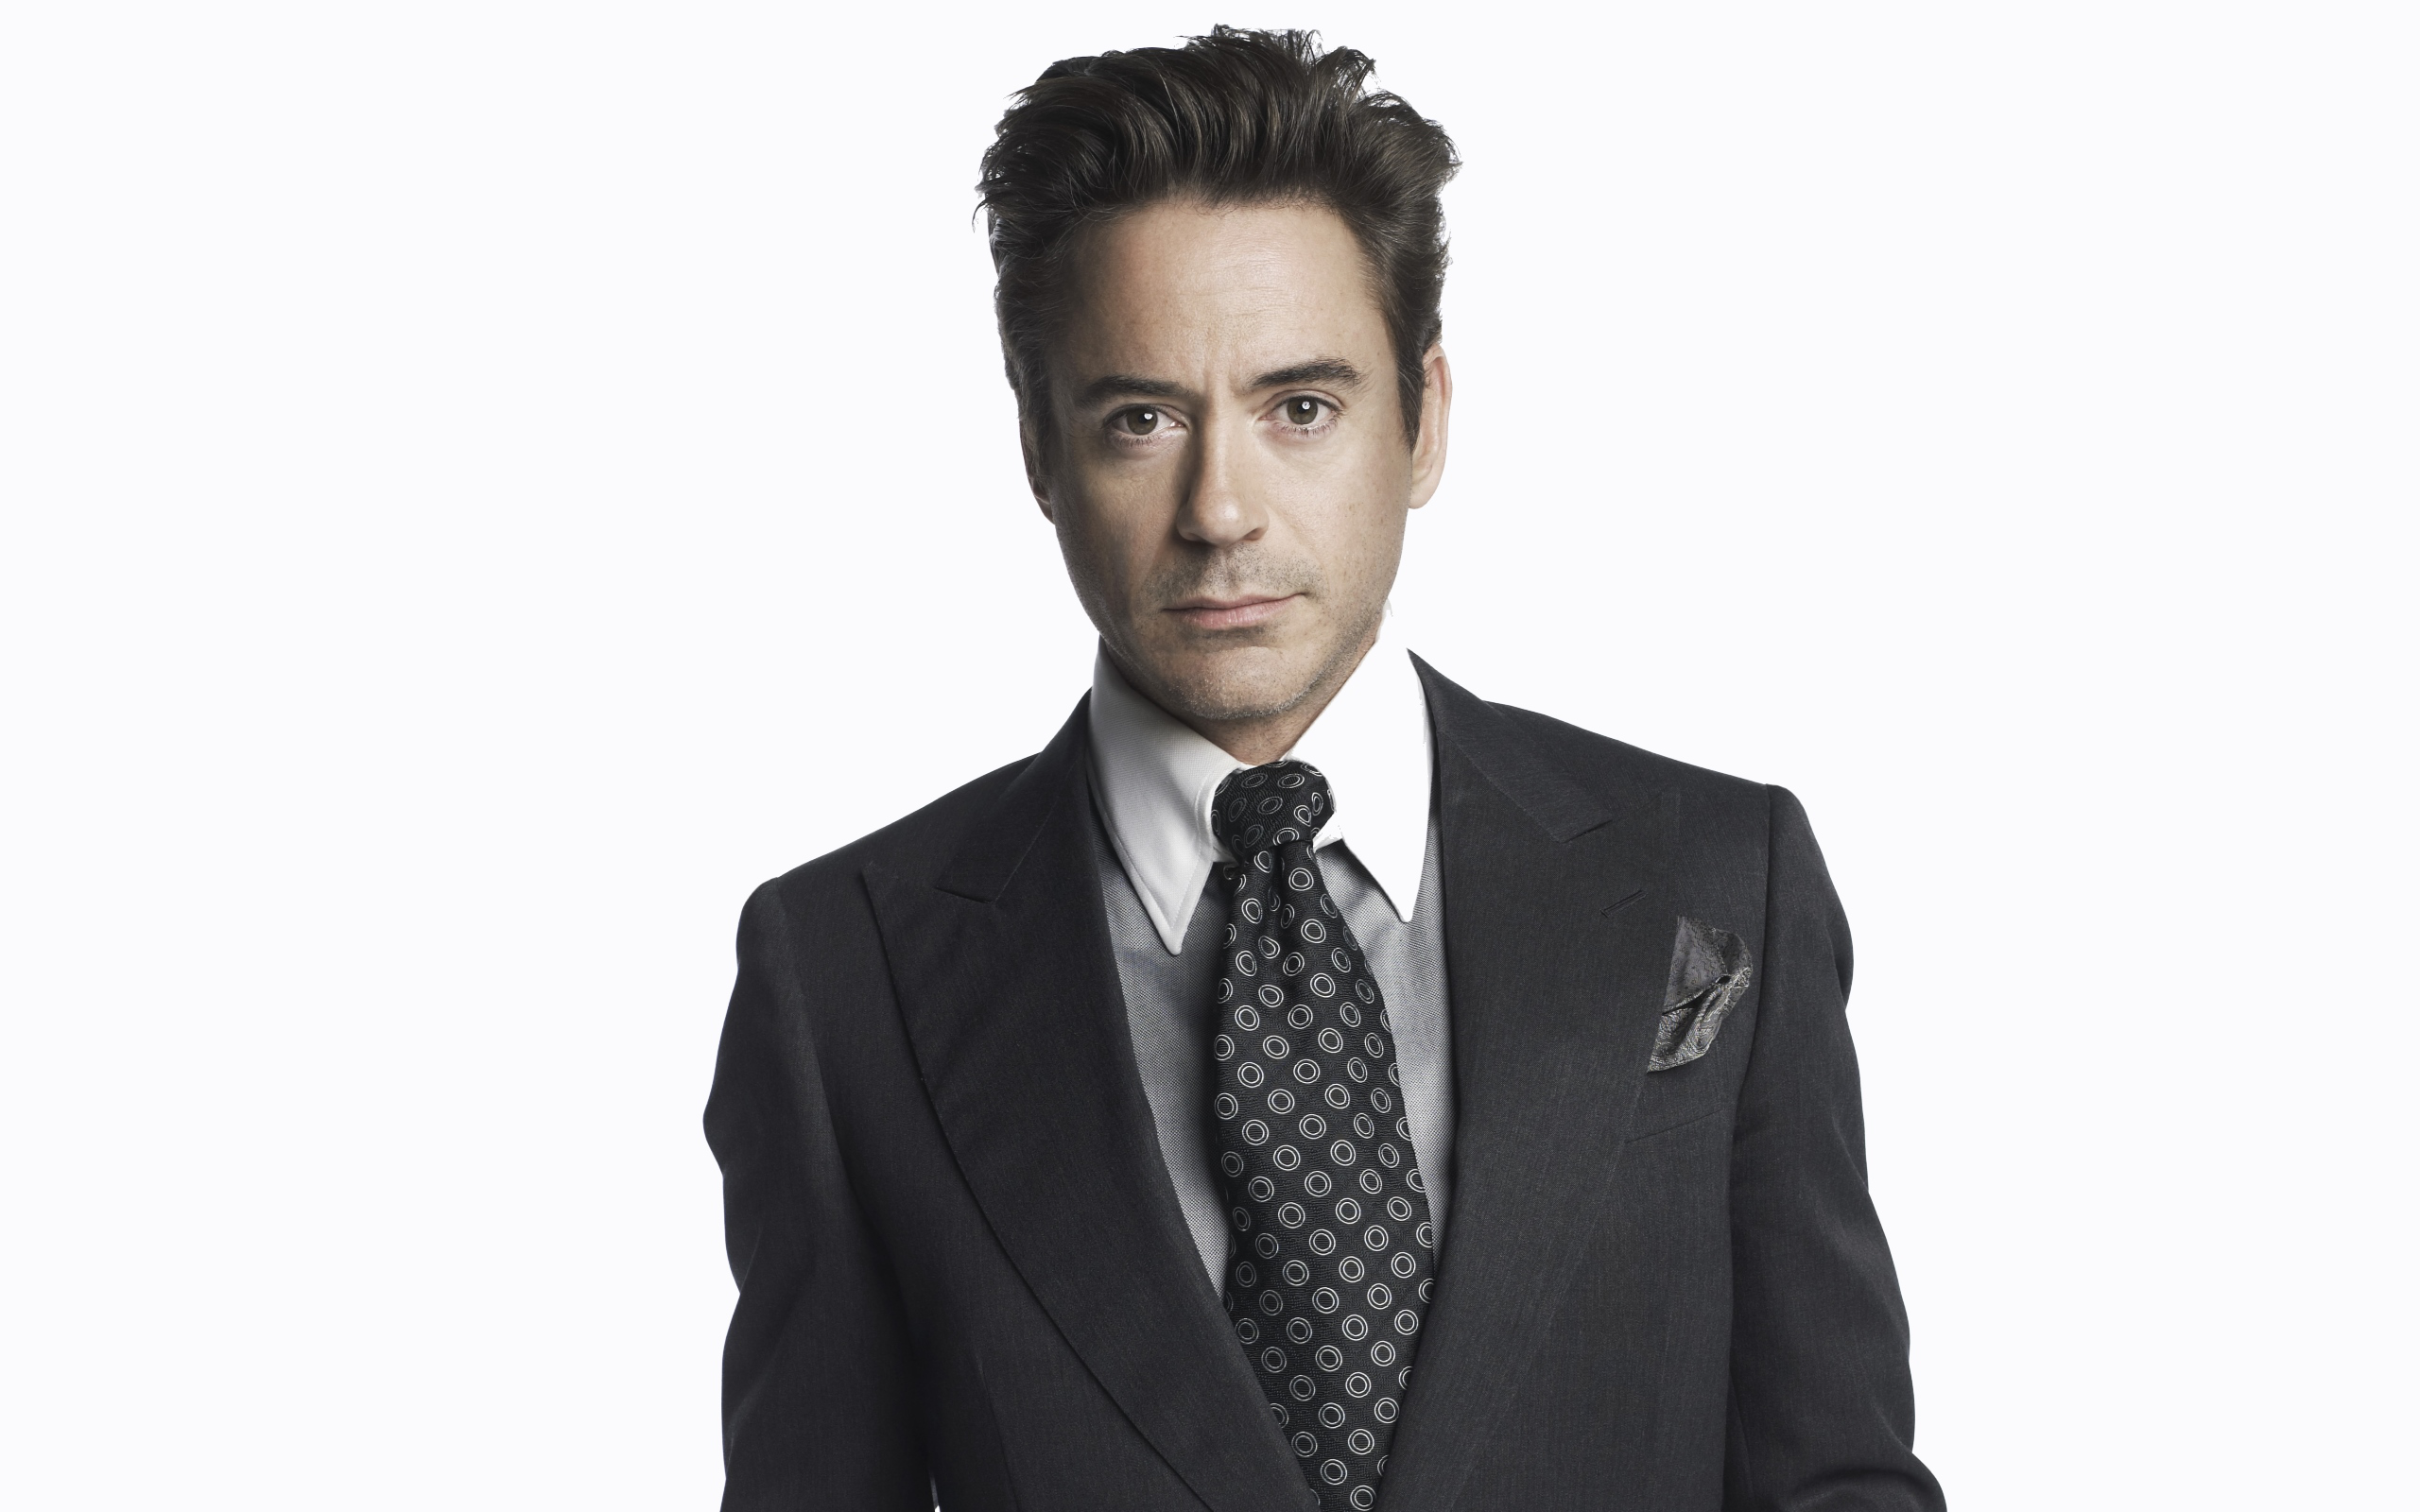

In [303]:
downey_jr_img

face size: (444, 444)


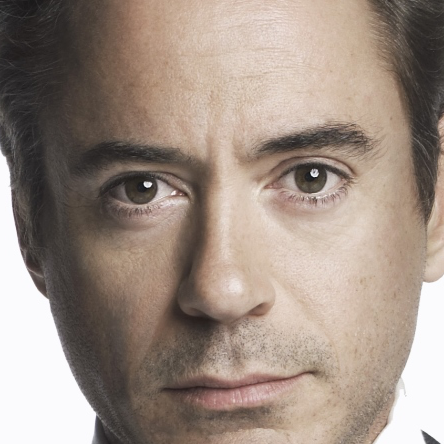

In [304]:
x0, y0, x1, y1 =  get_face_bbox(downey_jr_img)
downey_jr_face = downey_jr_img.crop((x0, y0, x1, y1))
face_size = downey_jr_face.size

print('face size: {}'.format(face_size))
downey_jr_face

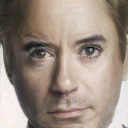

In [306]:
downey_jr_face = torchvision.transforms.Resize(IMAGE_SIZE)(downey_jr_face)
downey_jr_face_as_female = to_image(
    deep_feature_interpolation_cleared(downey_jr_face,
                                       source_mask, target_mask, 
                                       alpha=2.5)
)
downey_jr_face_as_female

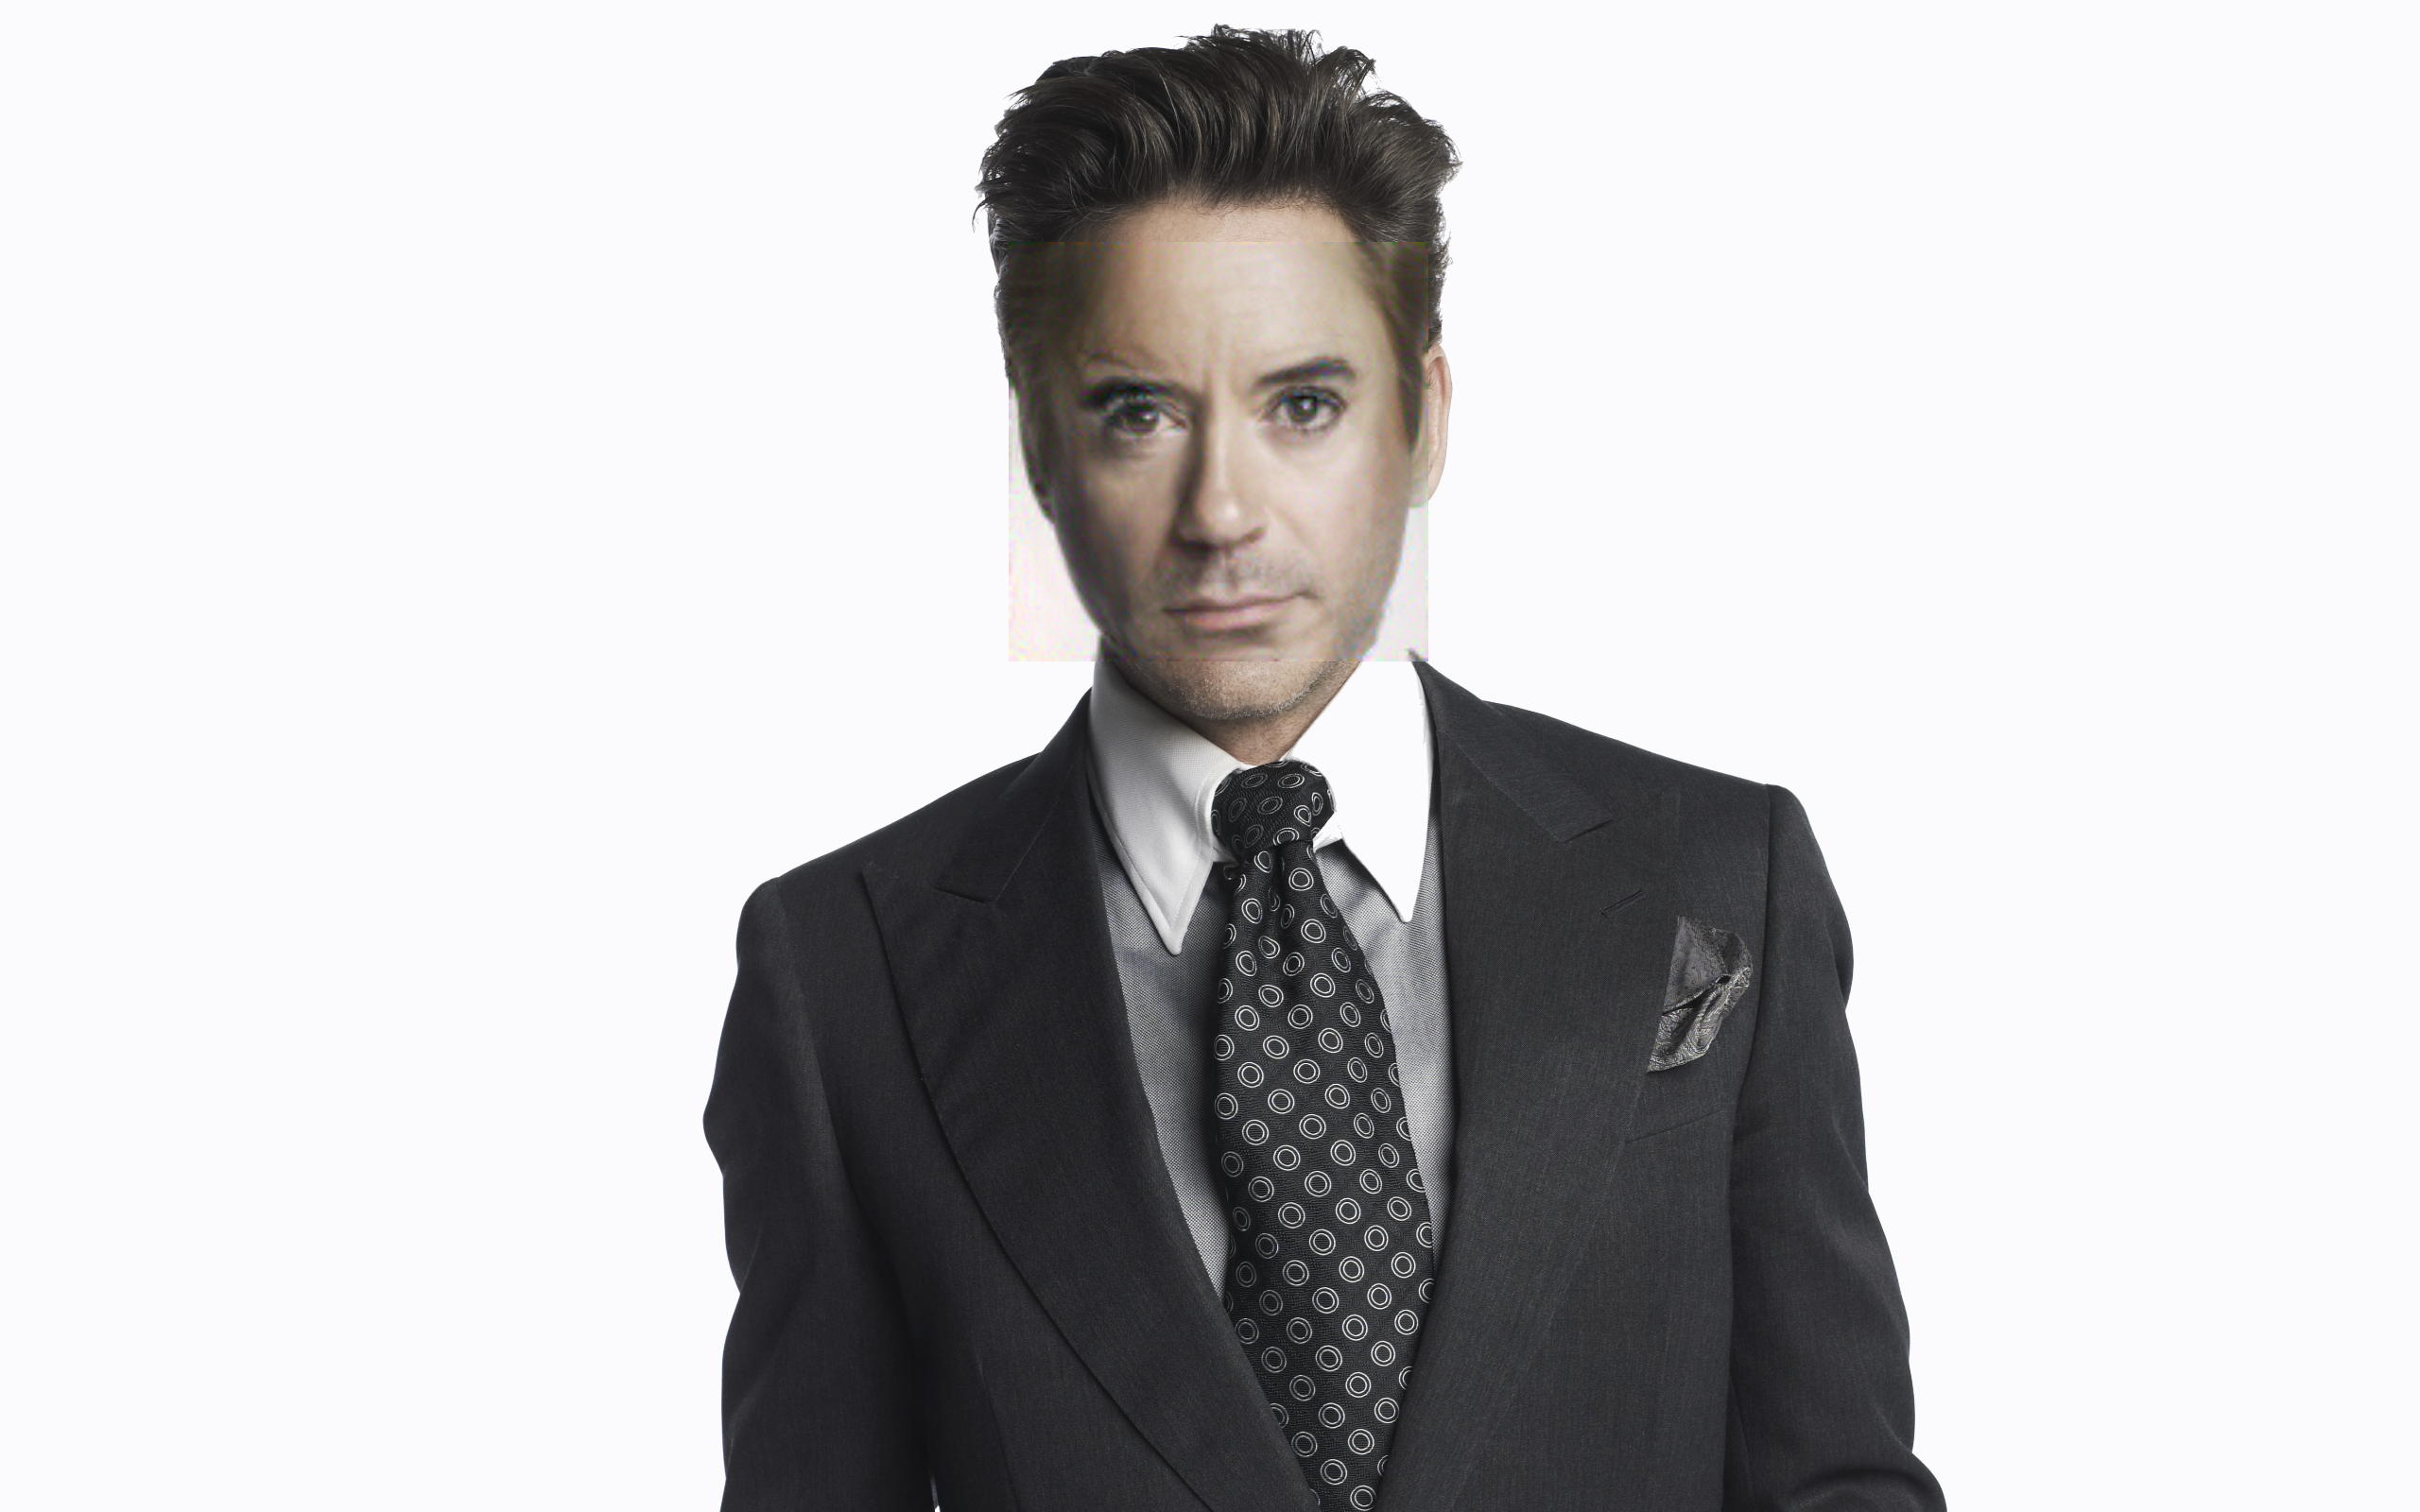

In [307]:
downey_jr_female_img = downey_jr_img.copy()
downey_jr_face_as_female = torchvision.transforms.Resize(face_size[0])(downey_jr_face_as_female)
downey_jr_female_img.paste(downey_jr_face_as_female, (x0, y0))
downey_jr_female_img